In [1]:
# setup
import sys
import os
sys.path.append(os.path.abspath('../src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import chi_square_test_multiple
from scipy import stats
import statsmodels.api as sm
from scipy.stats import chi2_contingency, pointbiserialr


# Looking closer at the features (Engineering, Correlation, ...)

In [2]:
df = pd.read_csv('../data/intermediate/clean_data_with_order_and_fees.csv', index_col=False)

In [3]:
df

,tmsp,country,amount,success,psp,3d_secured,card,order_id,hour_of_day,day_of_week,fee
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,1,0,1,1.0
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,1,0,1,3.0
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,2,0,1,1.0
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,2,0,1,3.0
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,3,0,1,0.5
...,...,...,...,...,...,...,...,...,...,...,...
50405,2019-02-28 23:45:39,Switzerland,415,0,UK_Card,0,Visa,27337,23,3,1.0
50406,2019-02-28 23:46:48,Austria,91,0,UK_Card,0,Master,27338,23,3,1.0
50407,2019-02-28 23:47:04,Austria,91,0,UK_Card,0,Master,27338,23,3,1.0
50408,2019-02-28 23:47:36,Austria,91,0,UK_Card,0,Master,27338,23,3,1.0


## Check correlations between feautures

In [4]:
df.dtypes

tmsp            object
country         object
amount           int64
success          int64
psp             object
3d_secured       int64
card            object
order_id         int64
hour_of_day      int64
day_of_week      int64
fee            float64
dtype: object

In [5]:
# ANOVA
# Null Hypothesis (H₀): No significant difference in mean fees between PSPs.
# Alternative Hypothesis (H₁): There is a significant difference in mean fees between at least two PSPs.

psp_groups = [df[df['psp'] == psp]['fee'] for psp in df['psp'].unique()]
f_statistic, p_value = stats.f_oneway(*psp_groups)

print(f"F-statistic: {f_statistic}, p-value: {p_value}")
## F-statistic: 39974.59124394523, p-value: 0.0 
## -> his result shows that the PSP variable has a strong influence on the fee charged 
## No surprise, the fees are derived from PSP

## --> remove fee as feature, we can also only use features that will be available when using the model anyways
df = df.drop('fee', axis=1)
df

F-statistic: 39974.59124394523, p-value: 0.0


,tmsp,country,amount,success,psp,3d_secured,card,order_id,hour_of_day,day_of_week
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,1,0,1
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,1,0,1
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,2,0,1
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,2,0,1
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,3,0,1
...,...,...,...,...,...,...,...,...,...,...
50405,2019-02-28 23:45:39,Switzerland,415,0,UK_Card,0,Visa,27337,23,3
50406,2019-02-28 23:46:48,Austria,91,0,UK_Card,0,Master,27338,23,3
50407,2019-02-28 23:47:04,Austria,91,0,UK_Card,0,Master,27338,23,3
50408,2019-02-28 23:47:36,Austria,91,0,UK_Card,0,Master,27338,23,3


## Check fee

In [6]:
correlation = df['hour_of_day'].corr(df['success'], method='spearman')
print(correlation)


0.008205890059376317


In [7]:
correlation = df['day_of_week'].corr(df['success'], method='spearman')
print(correlation)
correlation_pearson = df['day_of_week'].corr(df['success'], method='pearson')
print(correlation_pearson)


0.02404284309243208
0.02492190601641298


## Check Timestamp features
### We have previously derived day_of_week and hour_of_day for analysis purposes
- let's check if they could be helpful features

In [8]:
# Create a contingency table
contingency_table = pd.crosstab(df['day_of_week'], df['success'])

# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi2 statistic: {chi2}")
print(f"P-value: {p}")

Chi2 statistic: 51.898405030031455
P-value: 1.954627276467827e-09


In [9]:
# Build tiny model to look at model summary for evaluation
# Prepare the feature and target
X = df[['day_of_week']]  # Feature: day_of_week
X = sm.add_constant(X)   # Add constant term for intercept
y = df['success']       # Target: success

# Logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Display the summary of the model
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.504081
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                success   No. Observations:                50410
Model:                          Logit   Df Residuals:                    50408
Method:                           MLE   Df Model:                            1
Date:                Fri, 17 Jan 2025   Pseudo R-squ.:               0.0006146
Time:                        18:18:08   Log-Likelihood:                -25411.
converged:                       True   LL-Null:                       -25426.
Covariance Type:            nonrobust   LLR p-value:                 2.262e-08
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.4584      0.020    -73.965      0.000      -1.497      -1.420
day_of_week     0.0322    

- day_of_week does have a statistically significant relationship with success, but the effect size is small (log-odds increase of 0.0322).

In [10]:
contingency_table = pd.crosstab(df['hour_of_day'], df['success'])
display(contingency_table)


success,0,1
hour_of_day,,
0,1690,388
1,1671,422
2,1711,420
3,1775,410
4,1625,407
5,1716,416
6,1646,419
7,1690,395
8,1636,430


In [11]:
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi2 statistic: {chi2}")
print(f"P-value: {p}")

Chi2 statistic: 93.14407726269671
P-value: 2.0965079350326318e-10


In [12]:
X = df[['hour_of_day']]  # Feature
X = sm.add_constant(X)   # Add constant for intercept
y = df['success']        # Target

model = sm.Logit(y, X)   # Logistic regression
result = model.fit()
print(result.summary())  # Display model summary


Optimization terminated successfully.
         Current function value: 0.504358
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                success   No. Observations:                50410
Model:                          Logit   Df Residuals:                    50408
Method:                           MLE   Df Model:                            1
Date:                Fri, 17 Jan 2025   Pseudo R-squ.:               6.679e-05
Time:                        18:18:08   Log-Likelihood:                -25425.
converged:                       True   LL-Null:                       -25426.
Covariance Type:            nonrobust   LLR p-value:                   0.06534
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.4023      0.022    -64.938      0.000      -1.445      -1.360
hour_of_day     0.0029    

- hour_of_day does have a statistically significant relationship with success, but the effect size is small 

In [13]:
# In 02 we have seen that there is a slight peak in success between 13-18 
# Create a new feature for peak time (between 13:00 and 18:00)
df['is_peak_time'] = df['hour_of_day'].apply(lambda x: 1 if 13 <= x <= 17 else 0)
# Check the new feature
df[df['hour_of_day'].isin([12, 13])]

,tmsp,country,amount,success,psp,3d_secured,card,order_id,hour_of_day,day_of_week,is_peak_time
630,2019-01-01 12:00:04,Germany,158,0,Simplecard,0,Visa,264,12,1,0
631,2019-01-01 12:00:46,Germany,158,0,Moneycard,0,Visa,264,12,1,0
632,2019-01-01 12:03:01,Germany,101,0,UK_Card,0,Diners,265,12,1,0
633,2019-01-01 12:03:50,Germany,101,0,Simplecard,0,Diners,265,12,1,0
634,2019-01-01 12:05:16,Germany,328,0,UK_Card,0,Diners,266,12,1,0
...,...,...,...,...,...,...,...,...,...,...,...
50069,2019-02-28 13:50:38,Switzerland,109,0,Goldcard,1,Visa,27150,13,3,1
50070,2019-02-28 13:50:53,Switzerland,109,0,Simplecard,1,Visa,27150,13,3,1
50071,2019-02-28 13:51:31,Switzerland,109,1,Simplecard,1,Visa,27150,13,3,1
50072,2019-02-28 13:54:19,Switzerland,49,0,UK_Card,0,Visa,27151,13,3,1


In [14]:
# check chi -- two booleans
contingency = pd.crosstab(df['is_peak_time'], df['success'])
chi2, p, _, _ = chi2_contingency(contingency)
print(f"Chi-square test statistic: {chi2}, p-value: {p}")
## association between success and is_peak_time is statistically significant

Chi-square test statistic: 59.83966705795771, p-value: 1.0290821701357275e-14


In [15]:
# check cramer v's to get strength of observation
n = df.shape[0] 
cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))
print(f"Cramér's V: {cramers_v}")
## the strength of the association is very weak

Cramér's V: 0.03445372916883326


--> remove? Try the model later with and without-- but as shown in 02 the dat ais constructed, there are sales coming in at every hour of the day. Therefore the timestamp will probably not be beneficial here

## Categoricals

In [16]:
df['tmsp'] = pd.to_datetime(df['tmsp'])
df['success'] = df['success'].astype('object')
df['3d_secured'] = df['3d_secured'].astype('object')
df.dtypes

tmsp            datetime64[ns]
country                 object
amount                   int64
success                 object
psp                     object
3d_secured              object
card                    object
order_id                 int64
hour_of_day              int64
day_of_week              int64
is_peak_time             int64
dtype: object

- features are categorical and nominal -- no order, therefore onehot encoding
- success and 3d_secured are alreadz 0 or 1

In [17]:
# Run the function
results_df, connected_features, contingency_tables = chi_square_test_multiple(df)

# Display results
print("Chi-Square Results:")
print("=" * 80)
display(results_df)

print("\nConnected Features (Significant Associations):")
print("=" * 80)
if connected_features:
    print("\n".join([f"  - {pair[0]} ↔ {pair[1]}" for pair in connected_features]))
else:
    print("  No significant associations found.")

print("\nContingency Tables for Significant Associations (as Percentages):")
print("=" * 80)
if contingency_tables:
    for pair, table in contingency_tables.items():
        # Normalize the contingency table to percentages
        table_percentage = table / table.sum().sum() * 100
        print(f"Contingency table for {pair[0]} ↔ {pair[1]} (as Percentages):")
        print(table_percentage)
        print("-" * 80)
else:
    print("  No contingency tables to display.")

Null Hypothesis: There is no significant association between the two variables being tested.
Alternative Hypothesis: There is a significant association between the two variables.
Chi-Square Results:


,Feature 1,Feature 2,Chi2 Stat,p-value,Degrees of Freedom,Test Result,Is Significant,Cramér's V
0,country,success,1.130198,5.683038e-01,2,Fail to reject the null hypothesis (No signifi...,No,NaN
1,country,psp,7.259989,2.974715e-01,6,Fail to reject the null hypothesis (No signifi...,No,NaN
2,country,3d_secured,4.214435,1.215758e-01,2,Fail to reject the null hypothesis (No signifi...,No,NaN
3,country,card,10.254639,3.634996e-02,4,Reject the null hypothesis (Significant associ...,No,0.010085
4,success,psp,998.778385,3.312365e-216,3,Reject the null hypothesis (Significant associ...,No,0.140759
5,success,3d_secured,176.824451,2.392241e-40,1,Reject the null hypothesis (Significant associ...,No,0.059226
6,success,card,41.176299,1.144670e-09,2,Reject the null hypothesis (Significant associ...,No,0.028580
7,psp,3d_secured,0.874834,8.314963e-01,3,Fail to reject the null hypothesis (No signifi...,No,NaN
8,psp,card,16.040057,1.354058e-02,6,Reject the null hypothesis (Significant associ...,No,0.012613
9,3d_secured,card,8.937185,1.146344e-02,2,Reject the null hypothesis (Significant associ...,No,0.013315



Connected Features (Significant Associations):
  - card ↔ country
  - card ↔ psp
  - psp ↔ success
  - 3d_secured ↔ success
  - 3d_secured ↔ card
  - card ↔ success

Contingency Tables for Significant Associations (as Percentages):
Contingency table for card ↔ country (as Percentages):
card            Diners     Master       Visa
country                                     
Austria       3.822654  11.307280   4.388018
Germany      11.400516  34.572505  14.001190
Switzerland   4.153938  11.652450   4.701448
--------------------------------------------------------------------------------
Contingency table for psp ↔ success (as Percentages):
psp      Goldcard  Moneycard  Simplecard    UK_Card
success                                            
0        3.779012  12.858560   20.785558  42.287245
1        2.584805   3.600476    3.903987  10.200357
--------------------------------------------------------------------------------
Contingency table for 3d_secured ↔ success (as Percentages):
3d

- There are several significant associations 
- Most of these associations are weak, as indicated by the low values of cramer's V.

Significant Associations (Ordered by Strength):
- success vs psp - moderate
- success vs. 3d_secured - weak
- success vs. card - weak
- psp vs. card - very weak
- 3d_secured vs. card - very weak



## Amount

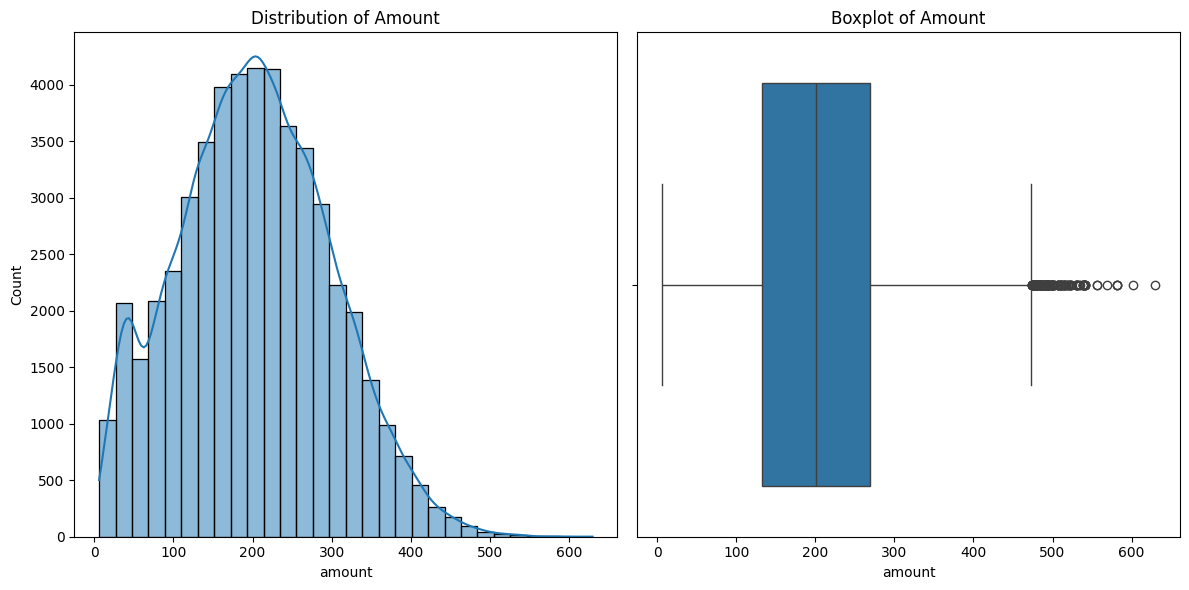

In [18]:
amount = df['amount']

plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(amount, kde=True, bins=30)
plt.title('Distribution of Amount')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=amount)
plt.title('Boxplot of Amount')

plt.tight_layout()
plt.show()


In [19]:
df['amount'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
amount,50410.0,202.395715,96.27473,6.0,133.0,201.0,269.0,630.0


- positively skewed, true outliers 
-- let's apply log transformation 

In [20]:
# Apply log transformation directly
df['amount_log'] = np.log(df['amount'])

df['amount_log'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
amount_log,50410.0,5.147129,0.659557,1.791759,4.890349,5.303305,5.594711,6.44572


- typical Pearson correlation wouldn't be ideal
-- point-biserial correlation test (one variable is continuous and the other is binary)

In [21]:
corr, p_value = pointbiserialr(df['amount_log'], df['success'])

print(f"Point-biserial correlation: {corr}")
print(f"P-value: {p_value}")

Point-biserial correlation: -0.08134298749588478
P-value: 9.386256233169355e-75


- very weak negative correlation
- statistical significance

## Summary 
- there is no single feature that seems to have a high correlation with success
- we do have multiple weak correlations though 

Handle features before modeling: 
- country, psp, card : OneHotEncoding
- sucess, 3d_secured: can stay, alread 1/0
- amount: log scaling

## check imbalances, across the different PSPs

In [26]:
total_records = df.shape[0]
print(f"Total number of records: {total_records}")

Total number of records: 50410


In [24]:
records_per_psp = df['psp'].value_counts()
print("Number of records per PSP:")
print(records_per_psp)

Number of records per PSP:
psp
UK_Card       26459
Simplecard    12446
Moneycard      8297
Goldcard       3208
Name: count, dtype: int64


Overall success/failure distribution:
success
0    40182
1    10228
Name: count, dtype: int64

Overall success/failure percentage distribution:
success
0    79.710375
1    20.289625
Name: proportion, dtype: float64


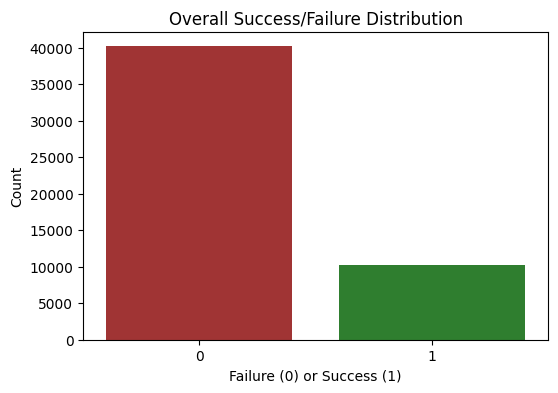


Success/Failure distribution within each PSP (Counts):
success         0     1
psp                    
Goldcard     1905  1303
Moneycard    6482  1815
Simplecard  10478  1968
UK_Card     21317  5142

Success/Failure distribution within each PSP (Percentages):
success             0          1
psp                             
Goldcard    59.382793  40.617207
Moneycard   78.124623  21.875377
Simplecard  84.187691  15.812309
UK_Card     80.566159  19.433841


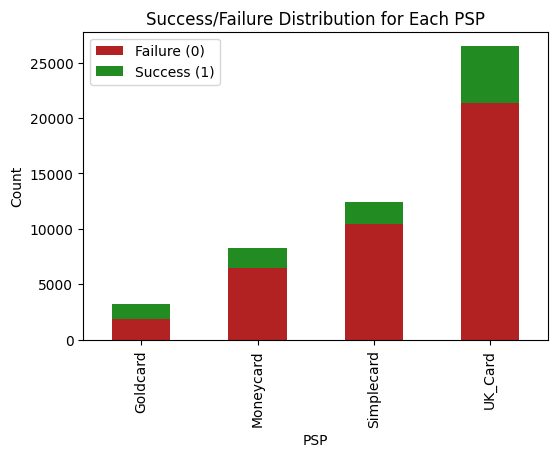

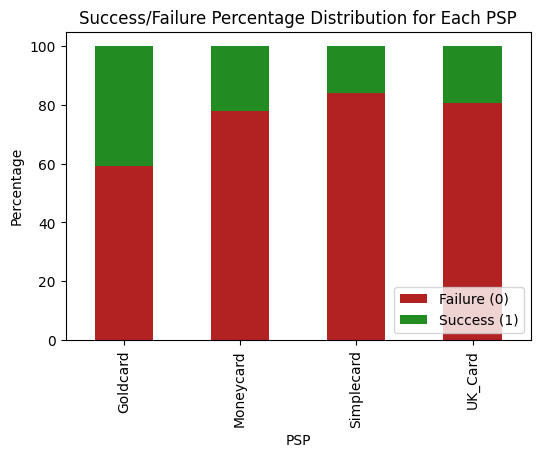

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check overall success/failure distribution
success_counts = df['success'].value_counts()
success_percentage = df['success'].value_counts(normalize=True) * 100
print("Overall success/failure distribution:")
print(success_counts)
print("\nOverall success/failure percentage distribution:")
print(success_percentage)

# Plot the success/failure distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='success', data=df, hue='success', palette={0: '#B22222', 1: '#228B22'}, legend=False)
plt.title('Overall Success/Failure Distribution')
plt.xlabel('Failure (0) or Success (1)')
plt.ylabel('Count')
plt.show()

# Check success/failure distribution within each PSP
psp_success_distribution = df.groupby('psp')['success'].value_counts().unstack().fillna(0)
psp_success_percentage = df.groupby('psp')['success'].value_counts(normalize=True).unstack().fillna(0) * 100

# Print success/failure counts and percentages within each PSP
print("\nSuccess/Failure distribution within each PSP (Counts):")
print(psp_success_distribution)
print("\nSuccess/Failure distribution within each PSP (Percentages):")
print(psp_success_percentage)

# Plot the success/failure distribution per PSP (Counts) with Forest Green and Firebrick
psp_success_distribution.plot(kind='bar', stacked=True, figsize=(6, 4), color=['#B22222', '#228B22'])
plt.title('Success/Failure Distribution for Each PSP')
plt.xlabel('PSP')
plt.ylabel('Count')
plt.legend(['Failure (0)', 'Success (1)'])
plt.xticks(rotation=90)
plt.show()

# Plot the success/failure percentage distribution per PSP with Forest Green and Firebrick
psp_success_percentage.plot(kind='bar', stacked=True, figsize=(6, 4), color=['#B22222', '#228B22'])
plt.title('Success/Failure Percentage Distribution for Each PSP')
plt.xlabel('PSP')
plt.ylabel('Percentage')
plt.legend(['Failure (0)', 'Success (1)'], loc='lower right')  
plt.xticks(rotation=90)
plt.show()


## There is a serious imbalance that needs to be treated!! 
- check weights also when it comes to modeling -- less weight on ecpensive psp?